In [ ]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import wandb
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from pathlib import Path
from bachelors_thesis.modeling.siglabv2.siglabv2 import SigLabV2
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.evaluation import set_level_accuracy, lead_level_accuracy , pretty_code_density_plot
from bachelors_thesis.utils import plot_ecg, confusion_matrix, hungarian_predictions, apply_preprocessors, PRECORDIAL_LEAD_NAMES, LEAD_NAMES
from bachelors_thesis.data.ptbxl_utility import get_ecg_signals_from_file
import seaborn as sns
import pandas as pd
import ast
from torchviz import make_dot
from IPython.display import Image
from collections import Counter
from scipy.ndimage import gaussian_filter1d

2025-05-08 17:33:16.981 | INFO     | bachelors_thesis.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


In [2]:
project_path = "nateml-maastricht-university/bachelors-thesis"
#run_id = "4zf4bqsa"
#run_id = "z1tihobt"
#run_id = "38ndk83w"
#run_id = "rg7rp176"
run_id = "f4k1i2bt"
artifact_name = "17_siglabv2_12leads"
version = "best"
#artifact_name = "00_siglabv2_test"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact(f"{project_path}/{artifact_name}:{version}")
artifact_path = artifact.download()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{artifact_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

wandb:   1 of 1 files downloaded.  


SigLabV2(
  (encoder): CNNGRUEncoder(
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(64, 32, kernel_size=(11,), stride=(1,), paddin

Loading the data

In [4]:
dataset_path = Path("../../" + cfg.dataset.path)
dataset_path = dataset_path.resolve()

val_data = np.load(dataset_path / "val.npy")

# Apply preprocessors
val_data = apply_preprocessors(val_data,
                               cfg.dataset.sampling_rate,
                               cfg.preprocessor_group.preprocessors)

# Convert to torch tensor
val_data = torch.from_numpy(val_data).float().to(device)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

# Create the dataset and dataloader
dataset = SigLocDataset(val_data)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

# Load metadata
meta = pd.read_csv(dataset_path / "meta_val.csv")
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))


torch.Size([2183, 12, 1000])


Forward pass through the model

In [5]:
c = cfg.model.num_classes
logits = np.zeros((len(dataset), c, c))
init_logits = np.zeros((len(dataset), c, c))
targets = np.zeros((len(dataset), c))

for idx, (signals, lead_labels) in enumerate(dataloader):
    signals = signals.to(device)
    lead_labels = lead_labels.to(device)

    if idx == 0:
        print(signals.shape)

    # Make predictions
    with torch.no_grad():
        these_logits, these_init_logits = model(signals)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
        init_logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_init_logits.cpu().numpy()
        targets[(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

print(logits.shape)

torch.Size([32, 12, 1000])
(2183, 12, 12)


Accuracy

In [6]:
#targets = torch.arange(c, device=logits[0].device).expand(logits.shape[0], -1)

if isinstance(logits, np.ndarray):
    logits = torch.from_numpy(logits).float()
if isinstance(init_logits, np.ndarray):
    init_logits = torch.from_numpy(init_logits).float()

probs = nn.functional.softmax(logits, dim=-1)

set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets)
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets)
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.9368
Lead level accuracy: 0.9867


In [7]:
# Accuracy of just precordial leads
# Get the indices of the precordial leads by checking where lead_labels are in [0, 1, 2, 3, 4, 5]
mask = np.isin(targets, [0, 1, 2, 3, 4, 5])
precordial_idxs = np.array([np.where(np.isin(targets, [0, 1, 2, 3, 4, 5])[i])[0] for i in range(len(targets))])

vals = targets[mask]
# Reshape to (batch_size, 6)
vals = vals.reshape(-1, 6)
precordial_logits = logits[mask].reshape(-1, 6, c)

precordial_set_acc = set_level_accuracy(logits=precordial_logits.cpu().numpy(), targets=vals)
precordial_lead_acc = lead_level_accuracy(logits=precordial_logits.cpu().numpy(), targets=vals)
print(f"Precordial set level accuracy: {precordial_set_acc:.4f}")
print(f"Precordial lead level accuracy: {precordial_lead_acc:.4f}")

Precordial set level accuracy: 0.9853
Precordial lead level accuracy: 0.9949


In [8]:
set_acc = set_level_accuracy(logits=init_logits.cpu().numpy(), targets=targets)
lead_acc = lead_level_accuracy(logits=init_logits.cpu().numpy(), targets=targets)
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.7975
Lead level accuracy: 0.9638


In [9]:
hungarian_preds = hungarian_predictions(logits.cpu().numpy())
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets)
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets)
print(f"Hungarian set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian set level accuracy: 0.9492
Hungarian lead level accuracy: 0.9882


In [10]:
hungarian_preds.shape

(2183, 12)

In [11]:
precordial_hungarian_preds = hungarian_preds[mask].reshape(-1, 6)
precordial_hung_set_acc = set_level_accuracy(predictions=precordial_hungarian_preds, targets=vals)
precordial_hung_lead_acc = lead_level_accuracy(predictions=precordial_hungarian_preds, targets=vals)
print(f"Precordial set level accuracy: {precordial_hung_set_acc:.4f}")
print(f"Precordial lead level accuracy: {precordial_hung_lead_acc:.4f}")

Precordial set level accuracy: 0.9895
Precordial lead level accuracy: 0.9955


# Find incorrect classifications

In [12]:
predictions = torch.argmax(logits, dim=-1).cpu().numpy()
mistake_mask = predictions != targets
mistake_counts = mistake_mask.sum(axis=1)
wrong = []
for i in range(1, 7):
    wrong.append(np.where(mistake_counts >= i)[0])

print(wrong[0])
print(len(wrong[0]))

[  36   52   75   76   78   92  100  111  146  161  166  167  169  185
  198  224  226  228  243  265  304  312  321  325  328  336  367  380
  387  419  463  468  470  479  483  502  509  524  567  578  632  669
  673  683  686  689  706  717  718  727  749  754  764  766  780  797
  828  837  838  883  905  927  936  947  948  955  956  961  966  971
  986  999 1004 1011 1019 1065 1067 1080 1083 1144 1198 1206 1215 1218
 1220 1222 1230 1240 1250 1260 1293 1296 1305 1306 1307 1320 1328 1379
 1407 1424 1431 1459 1468 1476 1484 1486 1512 1520 1547 1550 1595 1597
 1608 1610 1614 1632 1677 1691 1709 1729 1771 1790 1793 1808 1862 1866
 1878 1901 1911 1963 2004 2011 2027 2065 2075 2094 2150 2176]
138


trace only requested.


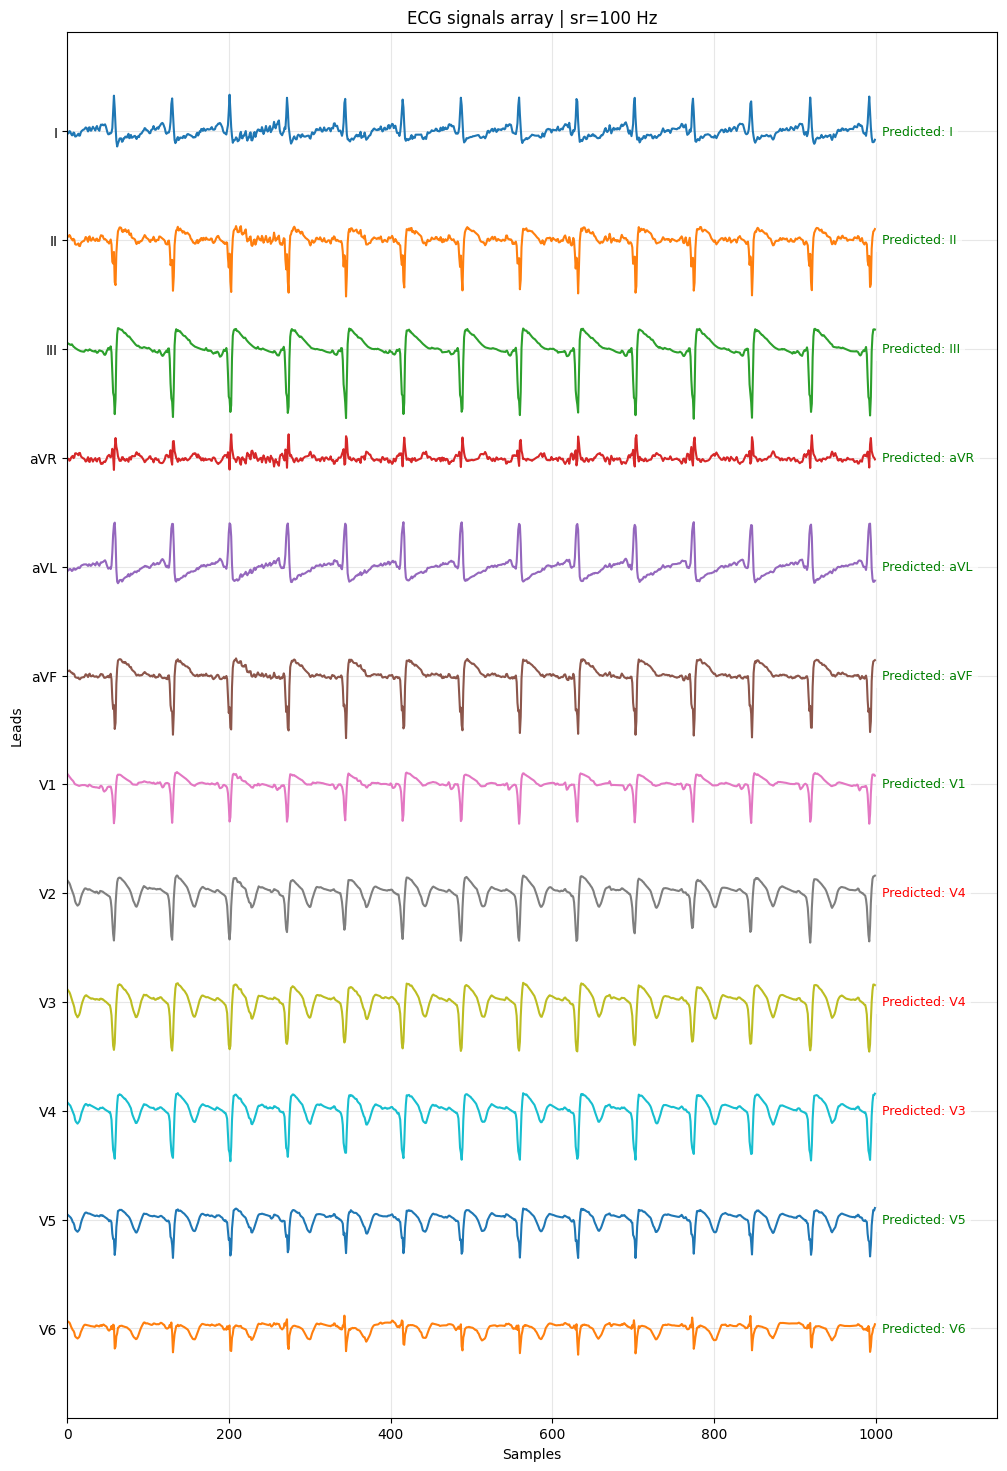

In [13]:
idx = wrong[0][1]
#idx = 0
signals = val_data[idx].cpu().numpy()
str_predictions = [LEAD_NAMES[p] for p in predictions[idx]]
plot_ecg(signals, sampling_rate=cfg.dataset.sampling_rate, predictions=str_predictions, leads=LEAD_NAMES)
print(meta.iloc[idx].report)

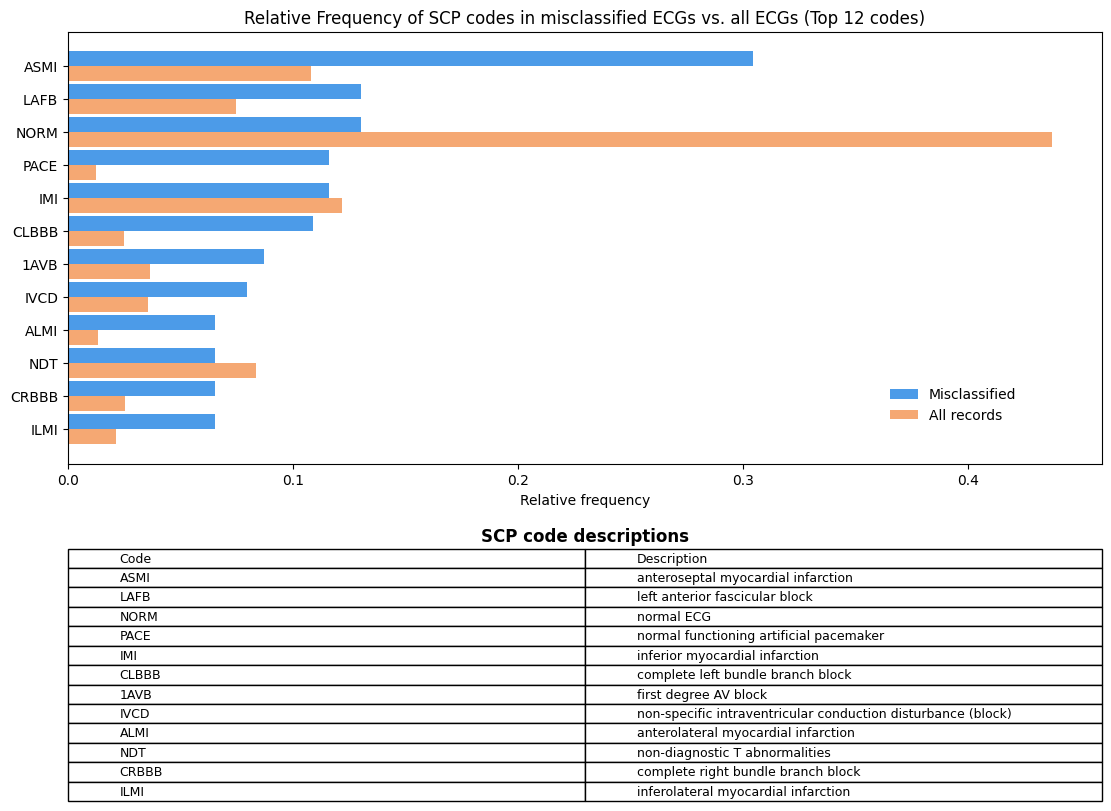

In [14]:
distribution = Counter(code
                       for codes in meta["present_codes"]
                       for code in codes)

outlier_distribution = Counter(code
                                for codes in meta.iloc[wrong[0]]["present_codes"]
                                for code in codes)

pretty_code_density_plot(
    distribution,
    outlier_distribution,
    n = 12,
    n_misclassified=len(wrong[0]),
    n_total=len(meta),
    relative=True,
    scp_statement_csv='../../data/raw/ptb-xl/scp_statements.csv',
)

In [15]:
# Calculate accuracy on pacemaker samples
pacemaker_idx = np.where(meta["present_codes"].apply(lambda x: "PACE" in x))[0]
print(len(pacemaker_idx))

pacemaker_acc = set_level_accuracy(predictions=predictions[pacemaker_idx])
pacemaker_acc

27


np.float64(0.4074074074074074)

In [16]:
int(np.max(targets) + 1)

12

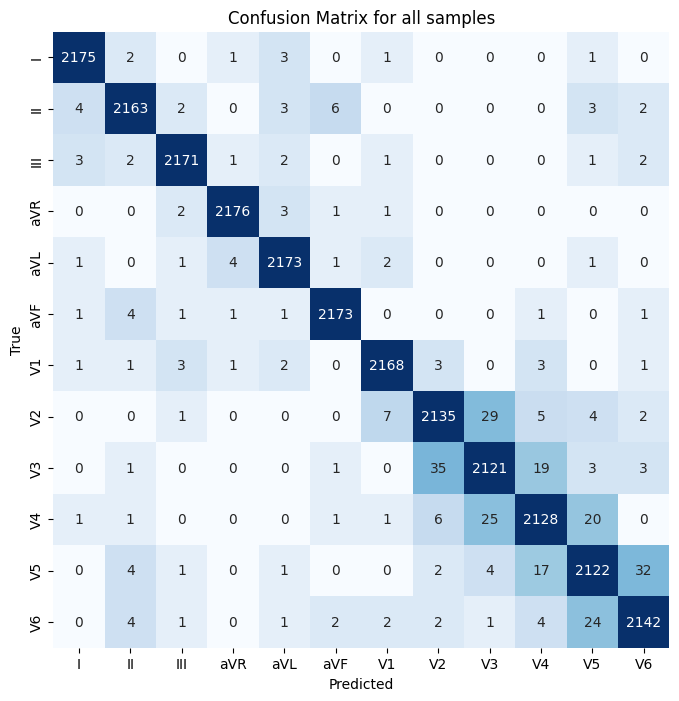

In [17]:
# Confusion matrix

cm = confusion_matrix(predictions, targets)
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Confusion Matrix for all samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    


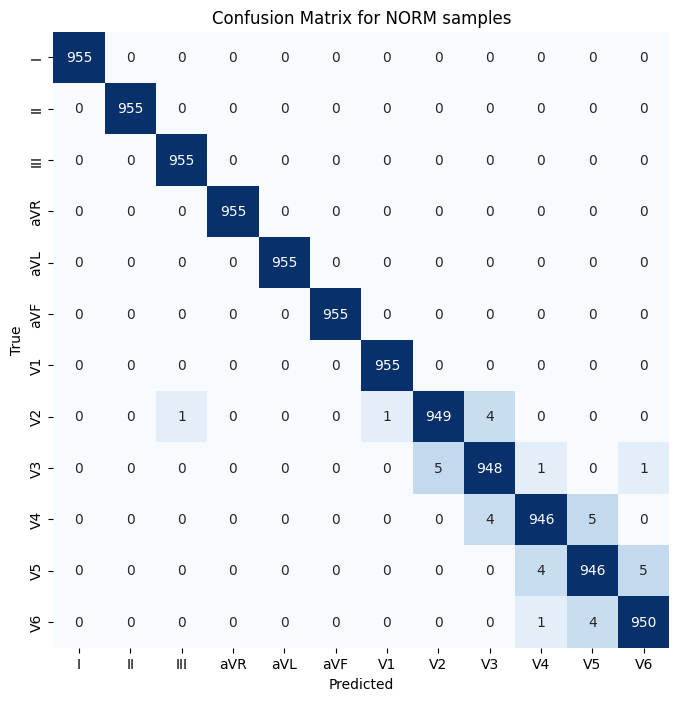

In [18]:
# Confusion matrix for NORM samples
norm_idx = np.where(meta["present_codes"].apply(lambda x: "NORM" in x))[0]

cm = confusion_matrix(predictions[norm_idx], targets[norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Confusion Matrix for NORM samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

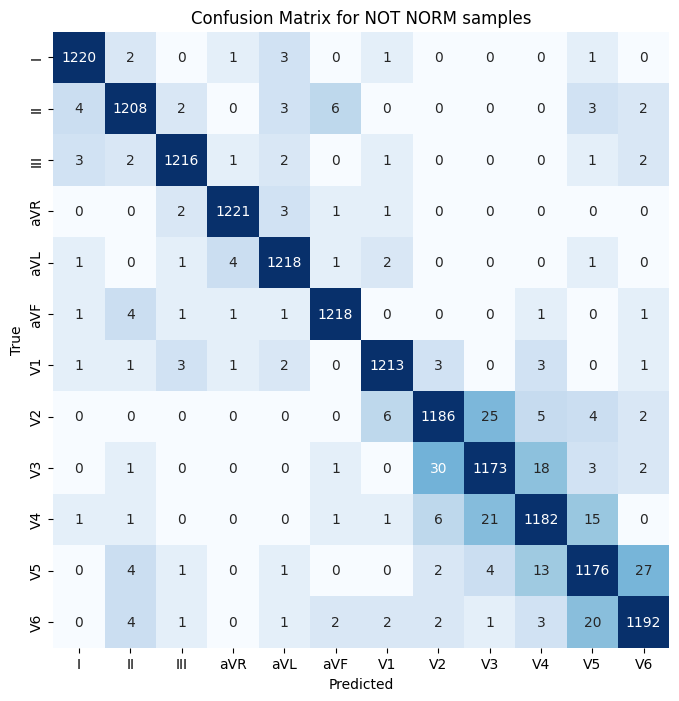

In [19]:
not_norm_idx = np.where(meta["present_codes"].apply(lambda x: "NORM" not in x))[0]

cm = confusion_matrix(predictions[not_norm_idx], targets[not_norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Confusion Matrix for NOT NORM samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

Normal:  955
Mycardial Infarction:  540
ST/T change:  528
Conduction disturbance:  495
Hypertrophy:  268


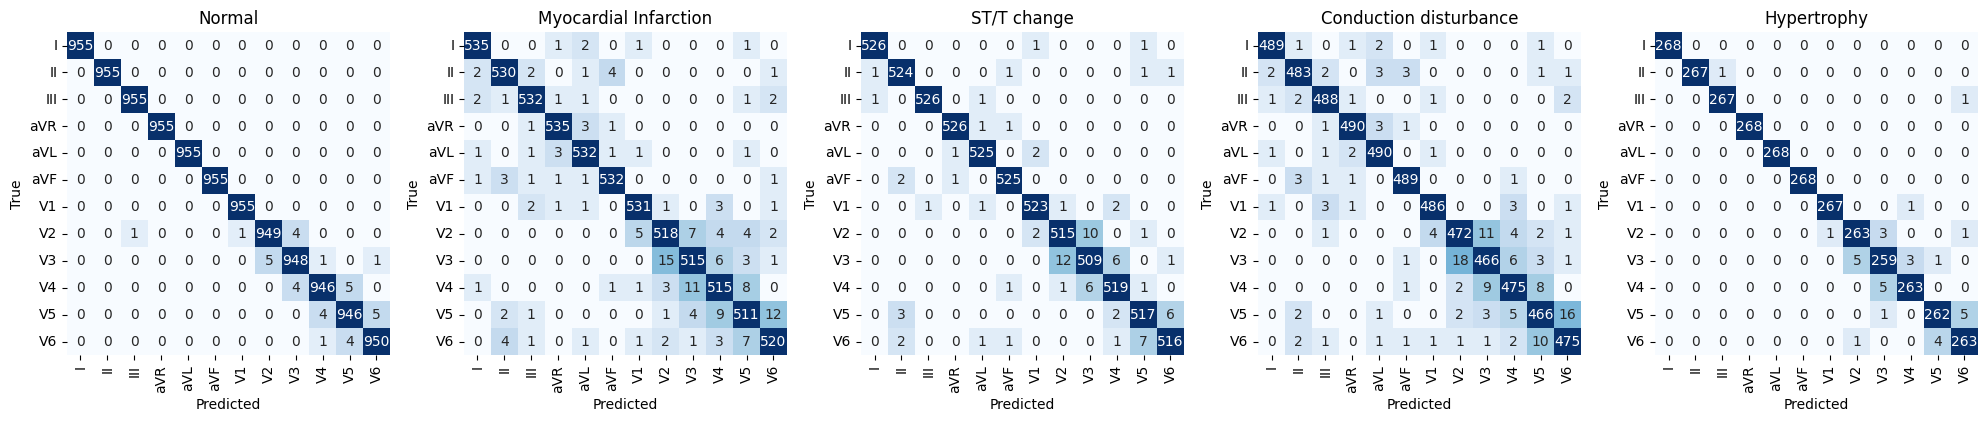

In [20]:
# Normal samples
norm_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "NORM" in x))[0]
print("Normal: ", len(norm_idx))

# Mycardial infarction samples
mi_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "MI" in x))[0]
print("Mycardial Infarction: ", len(mi_idx))

# ST/T change
sttc_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "STTC" in x))[0]
print("ST/T change: ", len(sttc_idx))

# Conduction disturbance
cd_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "CD" in x))[0]
print("Conduction disturbance: ", len(cd_idx))

# Hypertrophy
hypertrophy_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "HYP" in x))[0]
print("Hypertrophy: ", len(hypertrophy_idx))

# Calculate confusion matrices for each subset
cm_norm = confusion_matrix(predictions[norm_idx], targets[norm_idx])
cm_mi = confusion_matrix(predictions[mi_idx], targets[mi_idx])
cm_sttc = confusion_matrix(predictions[sttc_idx], targets[sttc_idx])
cm_cd = confusion_matrix(predictions[cd_idx], targets[cd_idx])
cm_hypertrophy = confusion_matrix(predictions[hypertrophy_idx], targets[hypertrophy_idx])

# Log-transform the confusion matrices for better visualization
cm_norm_log = np.log(cm_norm + 1)
cm_mi_log = np.log(cm_mi + 1)
cm_sttc_log = np.log(cm_sttc + 1)
cm_cd_log = np.log(cm_cd + 1)
cm_hypertrophy_log = np.log(cm_hypertrophy + 1)

# Visualize the confusion matrices
plt.figure(figsize=(20, 8))
plt.subplot(1, 5, 1)
sns.heatmap(cm_norm_log, annot=cm_norm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Normal")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 2)
sns.heatmap(cm_mi_log, annot=cm_mi, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Myocardial Infarction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 3)
sns.heatmap(cm_sttc_log, annot=cm_sttc, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("ST/T change")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 4)
sns.heatmap(cm_cd_log, annot=cm_cd, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Conduction disturbance")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 5)
sns.heatmap(cm_hypertrophy_log, annot=cm_hypertrophy, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=LEAD_NAMES, yticklabels=LEAD_NAMES)
plt.title("Hypertrophy")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Interpreting the model

In [21]:
sample = wrong[-1][0]
sample = 0
time_window = (0, 1000)

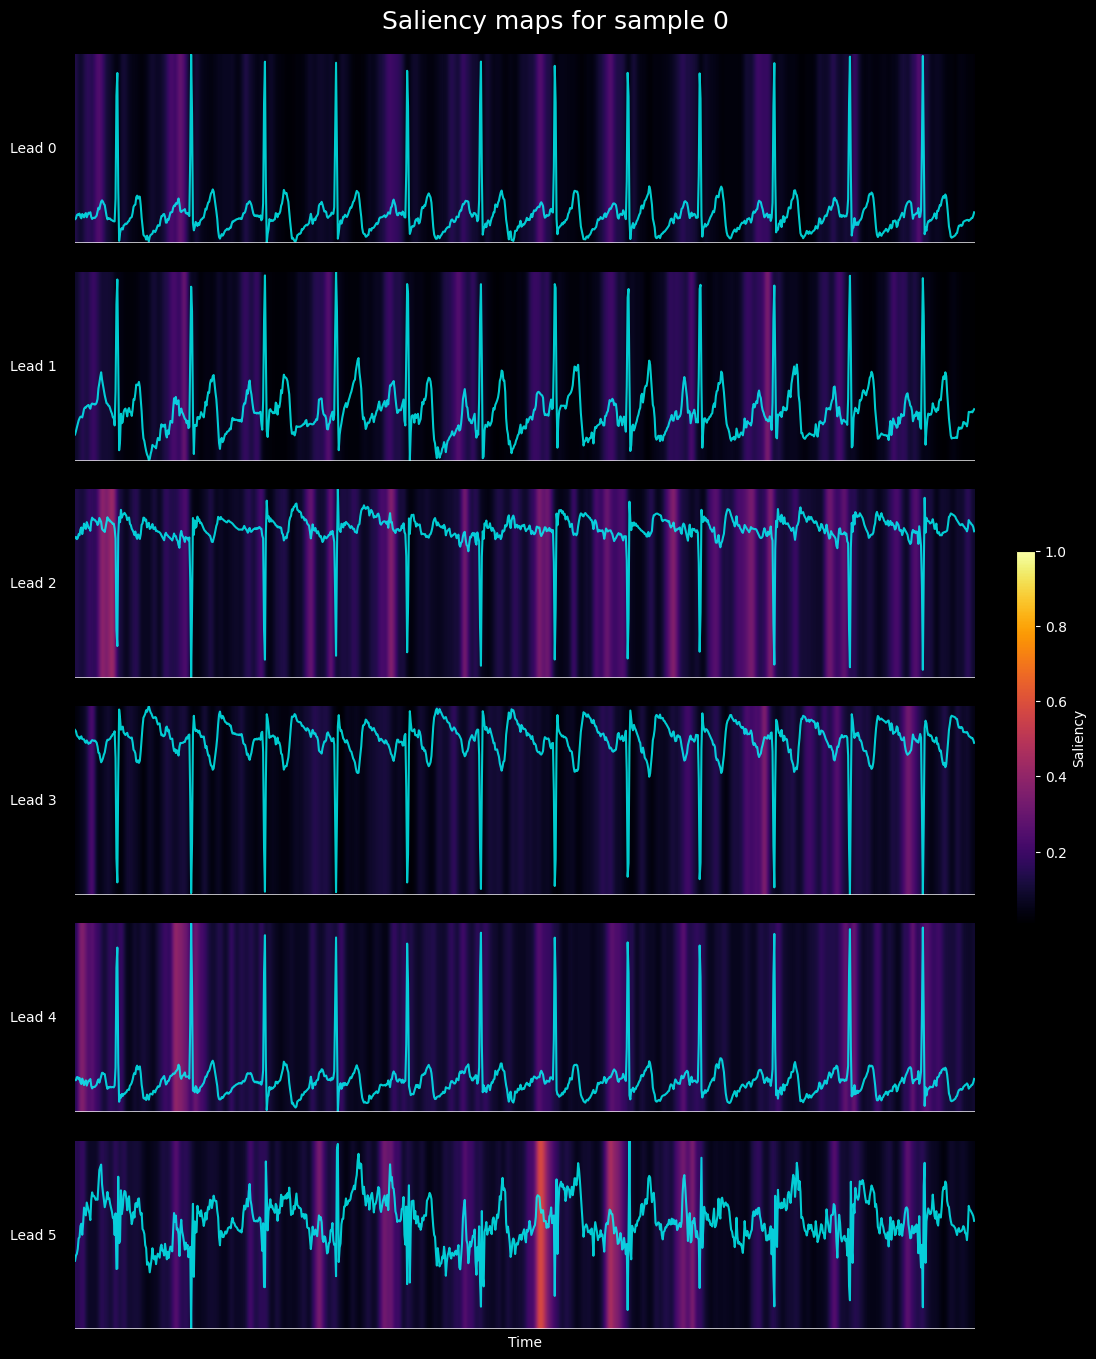

In [22]:
lead_indices = [0, 1, 2, 3, 4, 5]  # define the leads you want to visualize

x = val_data[sample].unsqueeze(0)  # shape [1, L, T]
x.requires_grad = True
x.to(device)

# put the model in train mode to get gradients
model.train()

# Get output and select the classification head output
output = model(x)[0][0]  # [num_leads, num_classes]

# Create subplots
num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()

## PCA

In [23]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(64, 32, kernel_size=(11,), stride=(1,), paddin

In [24]:
from sklearn.decomposition import PCA
from collections import defaultdict
from tqdm import tqdm

# ▸ 1. pick the layer you want to inspect
#     (example: model.encoder.cnn_post_layers[0] – an AdaptiveAvgPool1d)
# layer_to_hook = model.encoder.cnn_post_layers[2]   # <-- customise here
layer_to_hook = model.encoder   # <-- customise here

feature_store = []

def hook(module, inp, out):
    """
    Capture the tensor you care about.
    Expecting shape (B*N, D).
    """
    feature_store.append(out.detach().cpu())

hook_handle = layer_to_hook.register_forward_hook(hook)

# ▸ 2. run the model on a few batches and collect features
lead_labels  = []        # one lead label per feature vector
lead_vectors = []        # flattened feature vectors

dataloader = DataLoader(dataset,
                        batch_size=32,  
                        shuffle=False) 

model.eval()
n_batches = 20           # feel free to increase
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        if i >= n_batches: break
        x, _ = batch         # or whatever your DataLoader yields
        x = x.to(device)     # shape (B, C, 1000)
        _, *_ = model(x)         # populates feature_store

        feat   = feature_store.pop()  # (B*N, D)
        # Reshape to (B, N, D) if needed
        #feat   = feat.reshape(x.size(0), x.size(1), -1)  # (B, N, D)

        B = feat.shape[0]
        for b in range(B):  # Iterate over batch
            for lead in range(x.size(1)):            # Iterate over leads
                lead_vectors.append(feat[b, lead].numpy())         # Append the feature vector
                lead_labels .append(lead)            # 0…5

hook_handle.remove()

lead_vectors = np.vstack(lead_vectors)   # (samples, C_feat)
lead_labels  = np.array(lead_labels)     # (samples,)

 29%|██▉       | 20/69 [00:01<00:03, 15.59it/s]


In [25]:
lead_vectors.shape, lead_labels.shape

((7680, 128), (7680,))

In [26]:
# ▸ 3. PCA → 2-D
pca  = PCA(n_components=2, random_state=0)
proj = pca.fit_transform(lead_vectors)   # (samples, 2)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d                    # for smooth colour wheel

def pretty_pca_plot(xy, labels, title="Latent-space bouquet",
                    point_size=18, alpha_back=0.10, alpha_front=0.75,
                    pad=0.1):
    """
    xy       – (N,2) array of points
    labels   – (N,) array with integer lead IDs 0…5
    """
    # ------------------------------------------------------------
    # Set up a dark, minimal aesthetic
    # ------------------------------------------------------------
    mpl.rcParams.update({
        "figure.facecolor":   "#111216",
        "axes.facecolor":     "#111216",
        "axes.edgecolor":     "#888888",
        "axes.labelcolor":    "#CCCCCC",
        "xtick.color":        "#888888",
        "ytick.color":        "#888888",
        "axes.grid":          False,
        "font.size":          12,
    })
    plt.style.use("dark_background")

    # ------------------------------------------------------------
    # Build a smooth 12-colour circular palette
    # ------------------------------------------------------------
    base = np.array([
        [0.0, 0.0, 0.0],   # black
        [0.0, 0.0, 1.0],   # blue
        [0.0, 1.0, 1.0],   # cyan
        [0.0, 1.0, 0.0],   # green
        [1.0, 1.0, 0.0],   # yellow
        [1.0, 0.5, 0.0],   # orange
        [1.0, 0.0, 0.0],   # red
        [1.0, 0.0, 1.0],   # magenta
        [1.0, 0.5, 1.0],   # pink
        [1.0, 1.0, 1.0],   # white
        [1.0, 1.0, 1.5],   # white+
        [1.5, 1.5, 2.5]    # white++
    ])
    # tile + interpolate so colours wrap around smoothly
    base = np.vstack([base, base[0,None]])
    wheel = interp1d(np.linspace(0,12,13), base, axis=0)(np.arange(12))

    cm = plt.get_cmap("hsv", 12)

    # ------------------------------------------------------------
    # Two-layer scatter for subtle glow
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7,6), dpi=300)

    for k in range(len(labels)):
        idx = labels == k
        # back layer – large, low-alpha halo
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size*2,
                   color=cm(k), alpha=alpha_back, linewidths=0)
        # front layer – crisp centre
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size,
                   color=cm(k), alpha=alpha_front, linewidths=0)

    # ------------------------------------------------------------
    # Finishing touches
    # ------------------------------------------------------------
    ax.set_title(title, color="#E0E0E0", pad=12, weight="semibold")
    ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2")
    ax.set_aspect("equal", adjustable="datalim")

    ax.set_xlim(xy[:,0].min()-0.5, xy[:,0].max()+0.5)
    ax.set_ylim(xy[:,1].min()-0.5, xy[:,1].max()+0.5)

    # dark legend
    handles = [mpl.lines.Line2D([], [], color=wheel[k], marker="o", linestyle="",
                                markersize=6) for k in range(12)]
    ax.legend(handles,
              [f"Lead {k+1}" for k in range(12)],
              frameon=False, loc="lower right", labelcolor="#DDDDDD",
              fontsize=8, markerscale=0.8, handlelength=1.2)

    xmin, xmax = xy[:,0].min(), xy[:,0].max()
    ymin, ymax = xy[:,1].min(), xy[:,1].max()

    xrange = xmax - xmin
    yrange = ymax - ymin

    ax.set_xlim(xmin - pad * xrange, xmax + pad * xrange)
    ax.set_ylim(ymin - pad * yrange, ymax + pad * yrange)

    plt.tight_layout()
    plt.show()


ValueError: array([1. , 1. , 1.5]) is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


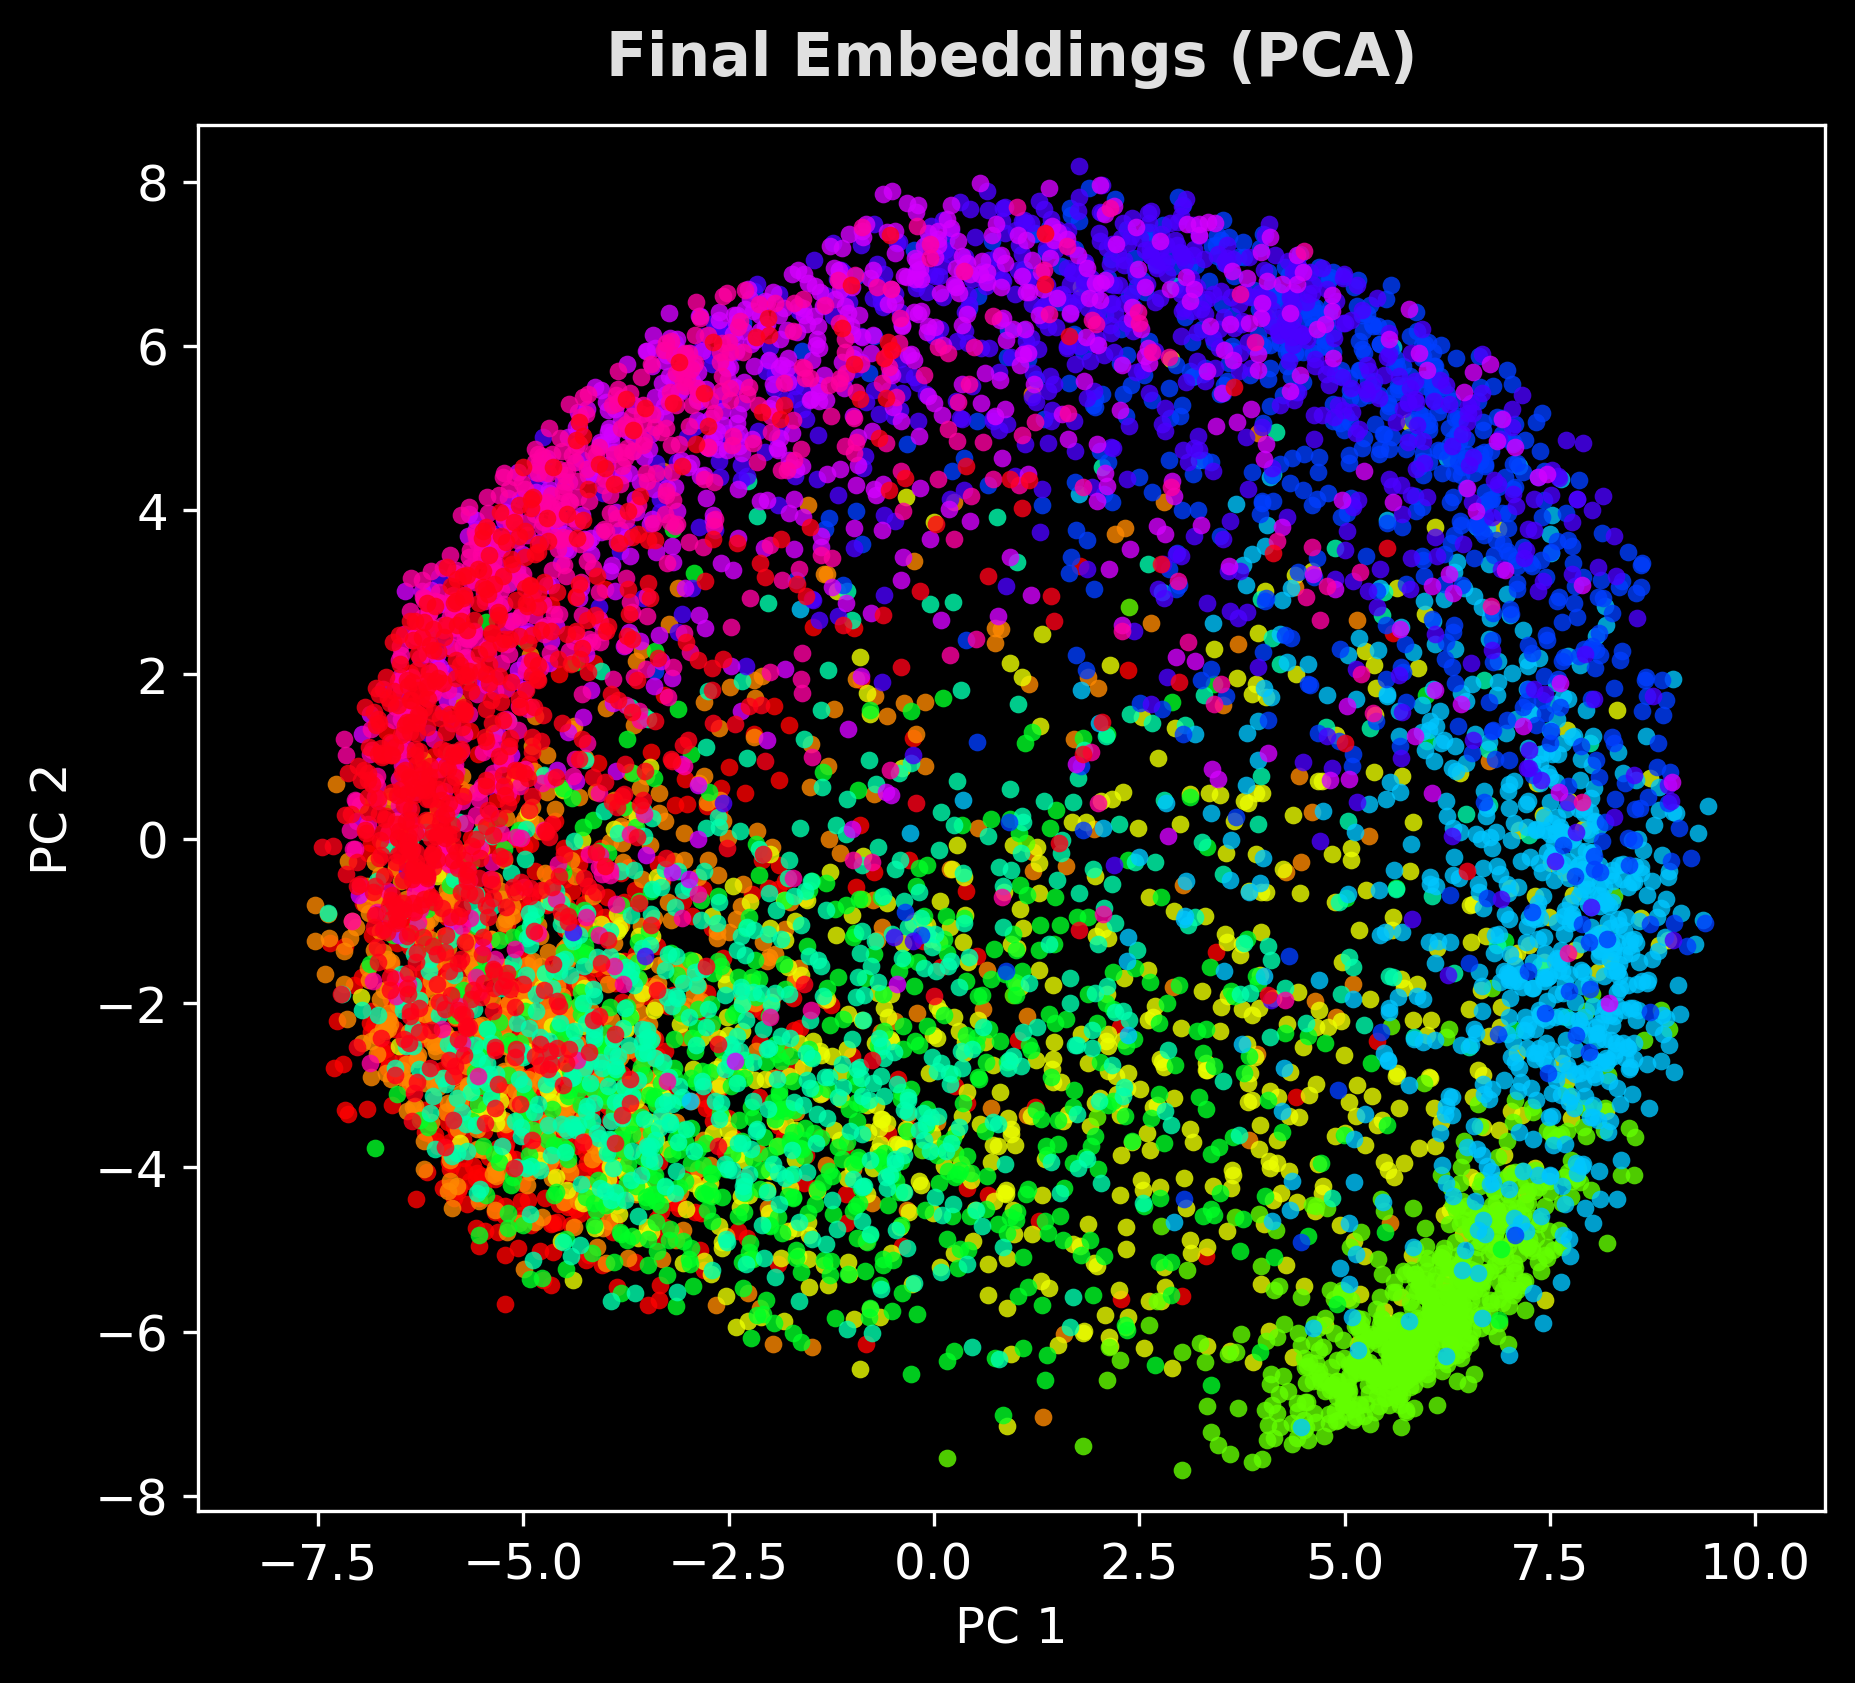

In [28]:
#%config InlineBackend.figure_format = 'retina'  # for high-res plots
plt.ion()
pretty_pca_plot(proj, lead_labels, title="Final Embeddings (PCA)", pad=0.25,
                alpha_front=0.8, alpha_back=0)

# Visualising Activations

In [ ]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 60, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(60, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 60, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(60, 32, kernel_size=(11,), stride=(1,), paddin

In [256]:
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# storage for intermediates
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
activation_trace = {}        # {layer_name: tensor[B, T]}
def make_hook(name):
    def _hook(module, inputs, output):
        # detach → no autograd, move to CPU for easy inspection
        activation_trace[name] = output.detach().cpu()
    return _hook

def gru_hook(module, inputs, output):
    out_seq, h_n = output
    activation_trace["gru"] = out_seq.detach().cpu()

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to the post-gru activations
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
model.encoder.gru.register_forward_hook(gru_hook)

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to every InceptionBlock
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
model.encoder.cnn_encoder[4].branch1.register_forward_hook(make_hook("branch1"))
model.encoder.cnn_encoder[4].branch2.register_forward_hook(make_hook("branch2"))
model.encoder.cnn_encoder[4].branch3.register_forward_hook(make_hook("branch3"))
model.encoder.cnn_encoder[4].branch5.register_forward_hook(make_hook("branch5"))


In [290]:
#sample = wrong[-1][0]
sample = 12
model.eval()                 # or model.train() if you want dropout etc.
with torch.no_grad():        # no need for gradients when just observing
    x = val_data[sample].unsqueeze(0).to(device)
    _ = model(x)             # forward pass populates logit_trace

In [291]:
lead = 1
gru_delta = activation_trace['gru'][lead][1:] - activation_trace['gru'][lead][:-1]
gru_curve = gru_delta.abs().sum(-1).cpu().numpy()
branch1_curve = activation_trace['branch1'][lead].sum(0).cpu().numpy()
branch2_curve = activation_trace['branch2'][lead].sum(0).cpu().numpy()
branch3_curve = activation_trace['branch3'][lead].sum(0).cpu().numpy()
branch5_curve = activation_trace['branch5'][lead].sum(0).cpu().numpy()

In [292]:
# Unpool to get activations to match the original input shape
T = 1000
L_c = branch1_curve.shape[0]
T_g = gru_curve.shape[0]
x_inp = np.linspace(0, 1, T)
branch1_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch1_curve)
branch2_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch2_curve)
branch3_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch3_curve)
branch5_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch5_curve)
gru_curve = np.interp(x_inp, np.linspace(0, 1, T_g), gru_curve)

branch1_curve.shape, branch2_curve.shape, branch3_curve.shape, branch5_curve.shape, gru_curve.shape

((1000,), (1000,), (1000,), (1000,), (1000,))

In [ ]:
# Visualise the activations of the gru_last layer
fig, axs = plt.subplots(6, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios':[3,2,2,2,2,2]})
axs[0].plot(val_data[sample][lead].cpu().numpy(), color='black', label='ECG')
axs[1].bar(np.arange(T), branch1_curve, color='red', label='Branch 1')
axs[2].bar(np.arange(T), branch2_curve, color='blue', label='Branch 2')
axs[3].bar(np.arange(T), branch3_curve, color='green', label='Branch 3')
axs[4].bar(np.arange(T), branch5_curve, color='orange', label='Branch 5')
axs[5].bar(np.arange(T), gru_curve, color='red', label='GRU')

plt.tight_layout()
plt.show()

[autoreload of numpy._core._type_aliases failed: Traceback (most recent call last):
  File "c:\Users\natem\bachelors_thesis\env\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\natem\bachelors_thesis\env\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Users\natem\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\natem\bachelors_thesis\env\lib\site-packages\numpy\_core\_type_aliases.py", line 21, in <module>
    from numpy._core.multiarray import typeinfo, dtype
ImportError: cannot import name 'typeinfo' from 'numpy._core.multiarray' (c:\U

shape: torch.Size([125, 128])


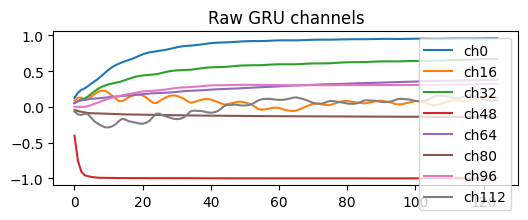

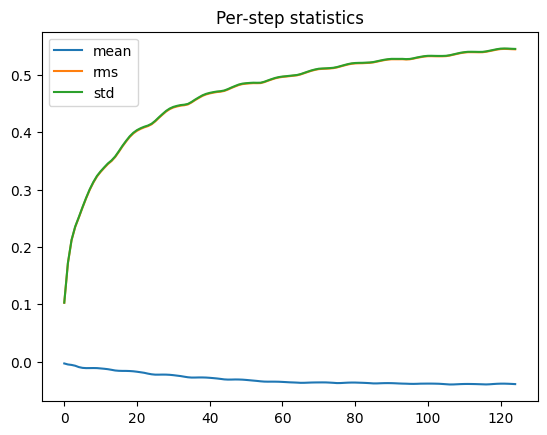

In [241]:
seq = activation_trace["gru"][0]           # (T=250, H=128) on CPU
print("shape:", seq.shape)

# (1) plot a handful of raw channels
plt.figure(figsize=(6,2))
for ch in range(0, 128, 16):
    plt.plot(seq[:, ch], label=f"ch{ch}")
plt.legend(); plt.title("Raw GRU channels"); plt.show()

# (2) signed mean, std and L2‑norm per step
signed = seq.mean(-1)
l2     = seq.pow(2).mean(-1).sqrt()
std    = seq.std(-1)

plt.plot(signed, label="mean")
plt.plot(l2,     label="rms")
plt.plot(std,    label="std")
plt.legend(); plt.title("Per‑step statistics"); plt.show()


Saliency

In [288]:
time_window = (0, 1000)
sample = 12
lead_indices = [0, 5]  # define the leads you want to visualize

In [289]:
x = val_data[sample].unsqueeze(0).to(device)  # shape [1, L, T]
x.requires_grad = True

output = model(x)[0]  # [num_leads, num_classes]

num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()

AttributeError: module 'numpy._core.multiarray' has no attribute 'ndarray'

<Figure size 1200x500 with 0 Axes>